# Predictive Brain Microcircuits
---

The point of this notebook is to connect Brian2 (a neuron spiking modelling system in Python) with PyHGF (A package meant for predictive brain modelling) to build a microcircuit -- mainly in the visual cortex for now.

## Setup and importing
This is really minimal -- we only need numpy and matplotlib.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


## A mockup, using only numpy

Based on previous research, e.g. [Wilmes et al, 2024](https://www.biorxiv.org/content/10.1101/2023.05.11.540393v7.full.pdf), we can create a rudimentary map of how the stimulus is processed:

             Sensory Input
                  ↓
              [PYR neurons]
               ↑    ↑
           (-) |    | (/)
              |     |
            SST     PV
            (mu)    (var)
               ↑    ↑
                \  /
                 VIP

In this notebook, we won't build a hierarchy or neural regions just yet. We'll start with the very basics:

A) A **stimulus** or input that is vaguely gaussian -- it has a mean and a variance.

B) A **belief/prior** - A region maintains assumptions about the mean and variance of the stimulus
  It also keeps a check on the **precision/confidence** of both the stimulus and belief.

C) A **prediction error** - The difference between the real stimulus and the predicted stimulus

D) A method to **update the beliefs** to get closer to reality. Using the above paper and others, we'll refine the mechanisms to not just be a generic leaky integration.

##### The input
We'll start by generating some input data. Each trial will contain 10 data points drawn from a normal distribution. Across the trials, the distribution changes subtly, with the mean and variance shifting slightly from trial to trial. This should allow us to study whether the internal model updates.
The specific parameters can be edited here:

In [ ]:
# Parameters
n_trials = 300
samples_per_trial = 30

mean_shift_std = 0.05
std_shift_std = 0.01

current_mean = 5
current_std = 2.0

# Containers
all_trials = []
means = [current_mean] #to start with
stds = [current_std]


# Generate trials
for i in range(n_trials):
    # Draw samples for each trial
    trial_data = np.random.normal(current_mean, current_std, samples_per_trial)

    # Ensure the variance isn't too close to 0 (guard against accidental collapse)
    if np.var(trial_data) < 1e-6:
        trial_data += np.random.normal(0, 1e-3, size=samples_per_trial)

    all_trials.append(trial_data) #adds the stimulus for each trial

    # Updates mean and std with slight shifts (you can change the shift intensity above)
    current_mean += np.random.normal(0, mean_shift_std)
    current_std += np.random.normal(0, std_shift_std)
    current_std = max(0.1, current_std)  # Ensuring std doesn't go too low

    means.append(current_mean) # so we know all the means and stds used
    stds.append(current_std)

#all_trials

First, we need a function to extract the mean and variance from the stimulus, as the sensory cortex does

In [ ]:
def sensory_stat(stimulus_array):
  return np.array([np.mean(stimulus_array), np.var(stimulus_array)])

Great, now on the other end, we need a model that updates. This is what is usually done by the prefrontal cortex (PFC), etc. For simplicity, let's just say that it maintains a mean and var.

###### **The update**
This could be done really using just a fixed alpha, as shown in alpha_update_beliefs() below. You update your mean and variance based on their individual prediction errors * (some fraction/ learning rate called alpha)

In [ ]:
#A rudimentary belief updater
def alpha_update_beliefs(current_beliefs, pred_error, alpha=np.array([0.5,0.5])):
  current_beliefs = current_beliefs + pred_error * alpha #alpha is an array with weights for mean and var prediction error
  return current_beliefs

However, the brain is a little bit more complicated than that, and we'll try to account for uncertainty, creating an evolving learning rate.

**For variance:**

The updating system for variance will be similar to the above function,but with some tweaks.
The below (commented out) function is unchanged, a basic bayesian leaky integrator, and is fun to play around with, since it converges with the real variance much faster.

In [ ]:
# def var_update(current_var, real_var, pred_error, alpha=0.01):
#     return max(current_var + alpha * (real_var - current_var), 1e-6)

Instead, for accuracy to neuroscience, we'll use the following update, using the prediction error (wrt the mean).
This model matches literature that suggests that our prior variance increases when surprise is high and decreases when the predictions are accurate. [This paper](https://arxiv.org/abs/2112.10048?utm_source=chatgpt.com) supports the idea

In [ ]:
def var_update(current_var, real_data, pred_error, alpha = 0.5):
  current_var  = current_var + alpha * (pred_error[0]**2 - current_var)
  return  max(current_var, 0.5)  # prevent collapse to zero

**For mean:**

However, the paper I cited above suggests that at each step, the updation is a Bayesian-precision wighted average
i.e. the confidence that the brain has in its current belief vs. the noisiness of the sensory data affects how much it changes that belief. The learning is thus adaptive, and is not a fixed increment percentage, like alpha. So we'll need another metric, precision = [precision_mean, precision_var]


> updated_belief = (belief_precision * prior_belief + sensory_precision * data) / (belief_precision + sensory_precision)

All of this requires us to know and update our value of precision.

In [ ]:
def mean_update(current_beliefs, real_data):
  pi_belief =  1.0 / current_beliefs[1] #pi being precision
  pi_sensory = 1.0/ real_data[1]

  mean_updated = (pi_belief * current_beliefs[0] + pi_sensory * real_data[0]) / (pi_belief + pi_sensory)
  return mean_updated

In [ ]:
def update_beliefs(current_beliefs, real_data, pred_error):
  var_updated = var_update(current_beliefs[1], real_data[1], pred_error)
  mean_updated = mean_update(current_beliefs, real_data)
  current_beliefs = np.array([mean_updated, var_updated])
  return current_beliefs

Let's keep a region that (in reality these regions calculate belief mean as well, since it's not represented as explicitly in the brain) calculates prediction error

In [ ]:
def p_error(current_beliefs, real_data):
  return real_data - current_beliefs

All together, the pipeline looks like this:

In [ ]:
current_beliefs = np.array([0,1])

for i in all_trials[:1]:
  real_data = sensory_stat(i)
  pred_error = p_error(current_beliefs, real_data)
  current_beliefs = update_beliefs(current_beliefs, real_data, pred_error)

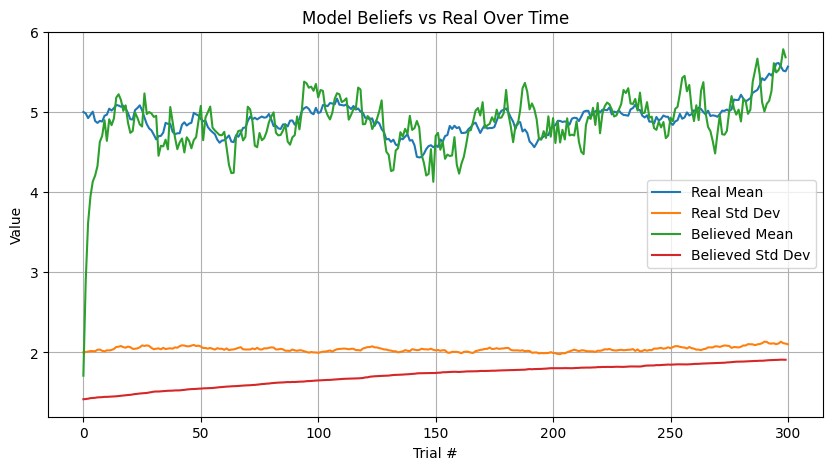

In [ ]:
beliefs_over_time = []
pred_error_over_time = []

current_beliefs = np.array([0.0, 2.0])  # Initial mean and var

for trial in all_trials:
    real_data = np.array(sensory_stat(trial))
    pred_error = p_error(current_beliefs, real_data)
    pred_error_over_time.append(pred_error.copy())
    current_beliefs = update_beliefs(current_beliefs, real_data, pred_error)
    beliefs_over_time.append(current_beliefs.copy())

beliefs_over_time = np.array(beliefs_over_time)
pred_error_over_time = np.array(pred_error_over_time)
vars = np.square(stds)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(means, label='Real Mean')
plt.plot(stds, label='Real Std Dev')
plt.plot(beliefs_over_time[:, 0], label='Believed Mean')
plt.plot(np.sqrt(beliefs_over_time[:, 1]), label='Believed Std Dev')
plt.title('Model Beliefs vs Real Over Time')
plt.xlabel('Trial #')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import linregress

slope_mean, _, _, _, _ = linregress(np.arange(len(pred_error_over_time[:,0])), pred_error_over_time[:,0])
slope_var, _, _, _, _ = linregress(np.arange(len(pred_error_over_time[:,1])), pred_error_over_time[:,1])

print(f"Mean Error Slope: {slope_mean:.4f}")
print(f"Var Error Slope: {slope_var:.4f}")
print("a negative slope, even a small one, does denote learning -- and since this stabilized within a few trials...")

Mean Error Slope: -0.0013
Var Error Slope: 0.0028
a negative slope, even a small one, does denote learning -- and since this stabilized within a few trials...


That was instructive, but not quite to the scale that I'd like

### Conclusions and whatnot

We can clearly see that the beliefs wrt the mean take input from the input and gets closer to reality, minimising error.
The variance, however isn't doing so well. This is a byproduct of combining pred_error of the mean with var -- it's less guaranteed to cause a convergence. For now, instead of optimizing the model, I'm going to make a more accurate one --incorporating hierarchies, python classes (for regions/combining multiple functions) and so on.
If you're interested, Part II is [here](https://colab.research.google.com/drive/13yCJlSI1rvHQ2J1xE5f7RTf9ReXKLW07?usp=sharing)

Thanks for dropping by


~ NB

Besides incorporating hierarchical processing, other directions to pursue include neuronal spiking (see below), trying different updation functions- a gradient descent approach, optimized for likelihood for instance. There is a *lot* of literature on neural simulation for a reason, and even in predictive behaviour, this little model can be scaled up a great deal.
For much larger models, or complex ones with pre-designed uncertainty and prediction, you can use Python packages like

**P.S:**
The below is something I started experimenting with, but left for the moment -- it's a possible future direction. I'm currently working with a very abstracted version of stimulus and neural activity.

However, real brain activity has many other constraints -- refractory periods, spiking activity, potential equations and their relations across synapses. Brian2 is a solid Python module for this purpose, generating neuron populations and simulating their dynamics.

I am confident I can simulate the more important behaviours of predictive behaviour in pure python (not spiking dynamics), so I set this aside for now.

In [ ]:
from brian2 import *
start_scope()
N = 50

# Neuron equations
eqs = '''
dv/dt = (-v + I)/ (10*ms) : 1
I : 1
'''

# Define populations
PYR = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
SST = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
PV  = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
VIP = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')

# External inputs
PYR.I = 'stim_input(t)'
SST.I = 'stim_input(t)'  # SST gets mean prediction
PV.I  = 'unc_input(t)'   # PV gets uncertainty (variance)
VIP.I = '0.2 + 0.2*randn()'  # Add surprise modulator later

# Connections (inhibitory unless noted)
SST_PYR = Synapses(SST, PYR, on_pre='v_post -= 0.2')
SST_PYR.connect(p=0.1)

PV_PYR = Synapses(PV, PYR, on_pre='v_post /= (1 + 0.5)')
PV_PYR.connect(p=0.1)

VIP_SST = Synapses(VIP, SST, on_pre='v_post -= 0.5')
VIP_SST.connect(p=0.1)

VIP_PV = Synapses(VIP, PV, on_pre='v_post -= 0.5')
VIP_PV.connect(p=0.1)

# Optional: plasticity in SST or PV
# You could later model SST synaptic adaptation to changing inputs (plastic prediction mean?)

# Monitors
mon_PYR = StateMonitor(PYR, 'v', record=range(3))
spikes_PYR = SpikeMonitor(PYR)
spikes_SST = SpikeMonitor(SST)
spikes_PV  = SpikeMonitor(PV)
spikes_VIP = SpikeMonitor(VIP)

# Run simulation
run(n_trials * ms)